In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [45]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

df = pd.DataFrame(data)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


#### Data preparation

In [46]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [47]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [48]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [49]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [50]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [51]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [52]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

#### Question 1: ROC AUC feature importance

In [57]:
scores = {}

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores[col] = auc

scores

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

#### Question 2: Training the model

In [58]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient = 'records')
val_dict = df_val[categorical + numerical].to_dict(orient = 'records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.817

#### Question 3: Precision and Recall

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

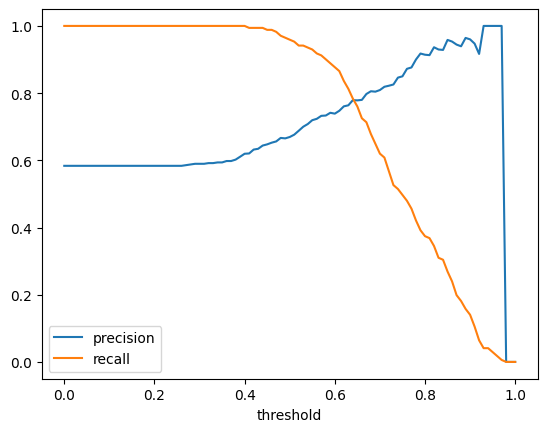

Precision ≈ Recall at threshold: 0.64
Precision ≈ Recall at threshold: 0.98
Precision ≈ Recall at threshold: 0.99
Precision ≈ Recall at threshold: 1.0


In [64]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision = []
recall = []

for t in thresholds:
    y_pred_thr = (y_pred >= t)
    p = precision_score(y_val, y_pred_thr)
    r = recall_score(y_val, y_pred_thr)
    precision.append(p)
    recall.append(r)

# plot them
plt.plot(thresholds, precision, label = 'precision')
plt.plot(thresholds, recall, label = 'recall')
plt.xlabel('threshold')
plt.legend()
plt.show()

for t, p, r in zip(thresholds, precision, recall):
    if abs(p - r) < 0.01:
        print("Precision ≈ Recall at threshold:", round(t, 3))

#### Question 4: F1 score

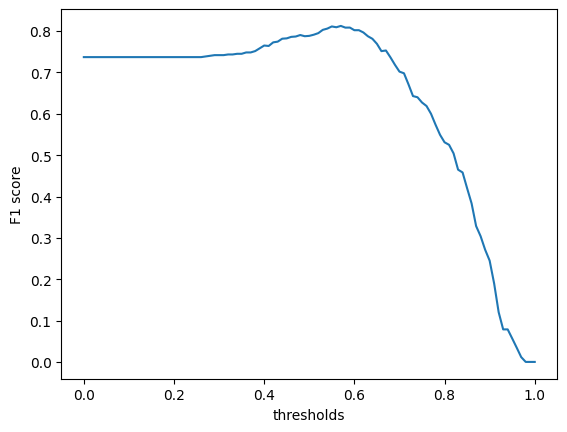

Best threshold for max F1: 0.57


In [66]:
f1_scores = []

for p, r in zip(precision, recall):
    if (p + r) == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(2 * p * r / (p + r))

plt.plot(thresholds, f1_scores)
plt.xlabel('thresholds')
plt.ylabel('F1 score')
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print('Best threshold for max F1:', round(best_threshold, 3))

#### Question 5: 5-Fold CV

In [75]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_idx]
    df_val_cv = df_full_train.iloc[val_idx]

    y_train_cv = df_train_cv.converted.values
    y_val_cv = df_val_cv.converted.values

    del df_train_cv['converted']
    del df_val_cv['converted']

    dict_train = df_train_cv[categorical + numerical].to_dict(orient = 'records')
    dict_val = df_val_cv[categorical + numerical].to_dict(orient = 'records')

    X_train_cv = dv.fit_transform(dict_train)
    X_val_cv = dv.transform(dict_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict_proba(X_val_cv)[:, 1]

    auc = roc_auc_score(y_val_cv, y_pred_cv)
    auc_scores.append(auc)

print('AUC scores:', auc_scores)
print('Mean:', round(np.mean(auc_scores), 3))
print('Std:', round(np.std(auc_scores), 3))

AUC scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean: 0.822
Std: 0.036


#### Question 6: Hyperparameter Tuning

In [76]:
C_values = [0.000001, 0.001, 1]
mean_scores = {}
std_scores = {}

for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx]
        df_val_cv = df_full_train.iloc[val_idx]

        y_train_cv = df_train_cv.converted.values
        y_val_cv = df_val_cv.converted.values

        del df_train_cv['converted']
        del df_val_cv['converted']

        dict_train = df_train_cv[categorical + numerical].to_dict(orient='records')
        dict_val = df_val_cv[categorical + numerical].to_dict(orient='records')

        X_train_cv = dv.fit_transform(dict_train)
        X_val_cv = dv.transform(dict_val)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict_proba(X_val_cv)[:, 1]

        auc = roc_auc_score(y_val_cv, y_pred_cv)
        auc_scores.append(auc)

    mean_scores[C] = round(np.mean(auc_scores), 3)
    std_scores[C] = round(np.std(auc_scores), 3)

print("Mean AUC per C:", mean_scores)
print("Std AUC per C:", std_scores)

best_C = max(mean_scores, key=mean_scores.get)
print("Best C:", best_C)


Mean AUC per C: {1e-06: np.float64(0.56), 0.001: np.float64(0.867), 1: np.float64(0.822)}
Std AUC per C: {1e-06: np.float64(0.024), 0.001: np.float64(0.029), 1: np.float64(0.036)}
Best C: 0.001
